In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

In [2]:
def histogramOfGradients(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bin_n = 16 # Number of bins
    bin = np.int32(bin_n*ang/(2*np.pi))
    bin_cells = []
    mag_cells = []
    cellx = celly = 8
    for i in range(0, img.shape[0]//celly):
        for j in range(0, img.shape[1]//cellx):
            bin_cells.append(bin[i*celly : i*celly+celly, j*cellx :j*cellx+cellx])
            mag_cells.append(mag[i*celly : i*celly+celly, j*cellx :j*cellx+cellx])
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
    # normalization
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= cv2.norm(hist) + eps
    return hist

In [4]:
image = cv2.imread("my_images/city.jpg",0)
hog = histogramOfGradients(image)

In [5]:
print(hog)

[0.00044818 0.00042652 0.         ... 0.00328094 0.0027741  0.00338504]


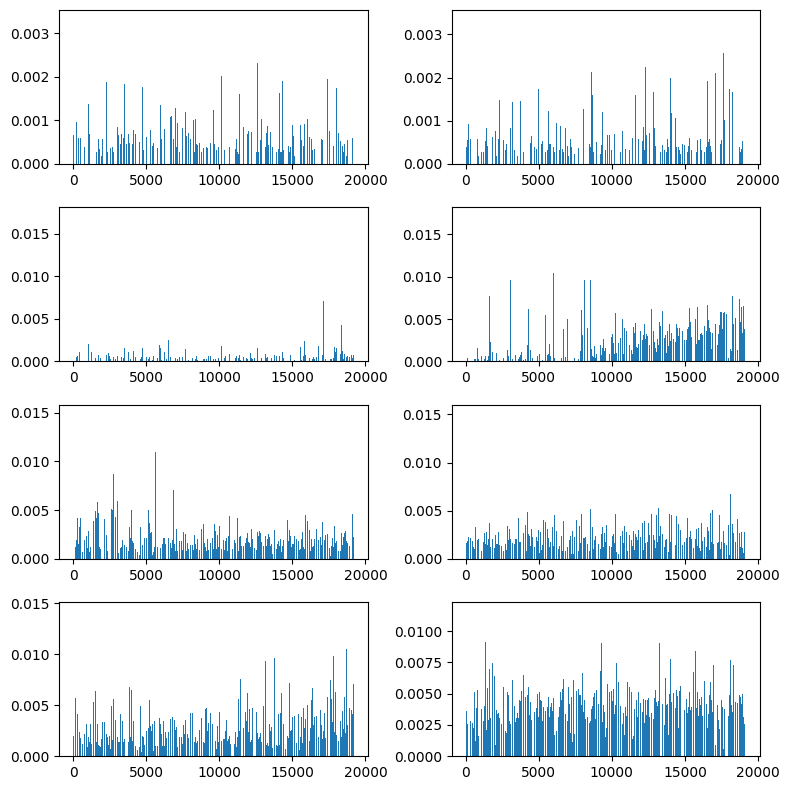

In [6]:
hog_reshaped = hog.reshape((4, 2, -1))
fig, axes = plt.subplots(nrows=hog_reshaped.shape[0], ncols=hog_reshaped.shape[1], figsize=(8, 8))

for i in range(hog_reshaped.shape[0]):
    for j in range(hog_reshaped.shape[1]):
        axes[i, j].bar(np.arange(len(hog_reshaped[i, j])), hog_reshaped[i, j])
        # axes[i, j].set_title(f'Cell {i+1}-{j+1}')

plt.tight_layout()
plt.show()

In [7]:
image = cv2.imread("my_images/city.jpg",0)
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 16
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog =cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
#compute(img[, winStride[, padding[, locations]]]) -> descriptors
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)
hist = hog.compute(image,winStride,padding,locations)

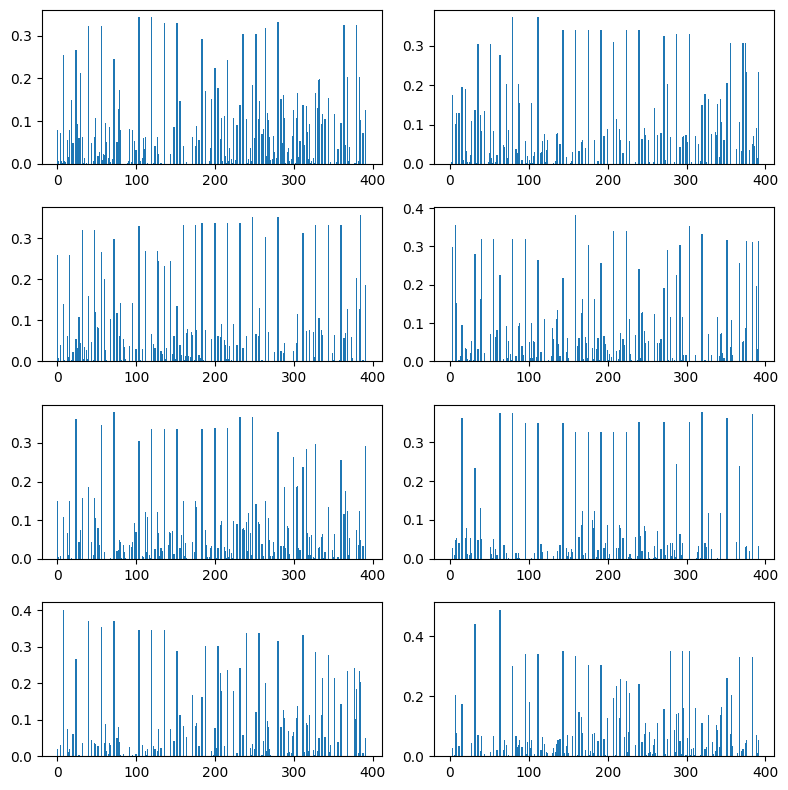

In [8]:
hog_reshaped = hist.reshape((4, 2, -1))
fig, axes = plt.subplots(nrows=hog_reshaped.shape[0], ncols=hog_reshaped.shape[1], figsize=(8, 8))

for i in range(hog_reshaped.shape[0]):
    for j in range(hog_reshaped.shape[1]):
        axes[i, j].bar(np.arange(len(hog_reshaped[i, j])), hog_reshaped[i, j])
        # axes[i, j].set_title(f'Cell {i+1}-{j+1}')

plt.tight_layout()
plt.show()

# Homework

In [1]:
import os
import cv2
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

In [51]:
class HoGProcessor:
    def __init__(self, neg_data='neg_person', pos_data='pos_person', win_size=(64, 64),cell_size=(16,16), block_size=(32,32),block_stride=(16,16), num_bins=9 ):
        self.neg_data_path = neg_data
        self.pos_data_path = pos_data
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.num_bins = num_bins
        self.win_size = win_size
        self.hog = None
        self.model = LinearSVC()
        
    
    def check_images_shape(self):
        pos_size = set()
        neg_size = set()
        for image_path in os.listdir(self.pos_data_path):
            image = cv2.imread(self.pos_data_path+'/'+image_path)
            pos_size.add(image.shape)
        for image_path in os.listdir(self.neg_data_path):
            image = cv2.imread(self.neg_data_path+'/'+image_path)
            neg_size.add(image.shape)
        print("pos_images set shape", pos_size)
        print("neg_images set shape", neg_size)
    
    def computeHOG(self,image,init_hog=False):
        if self.hog==None or init_hog==True:
            self.hog = cv2.HOGDescriptor(self.win_size,self.block_size,self.block_stride,self.cell_size,self.num_bins)
        hist = self.hog.compute(image)
        return hist
    
    
    def generate_features(self,data_path):
        images = os.listdir(data_path)
        print(len(images),"to process")
        image_path = data_path+'/'+images[0]
        image = cv2.imread(image_path)
        print("Image shape:", image.shape)
        hist = self.computeHOG(image)
        print("Hist length:", len(hist))
        np_array = np.zeros(shape=(len(images),len(hist)))
        print("np array shape:",np_array.shape)
        for i in range(len(images)):
            image_path = data_path+'/'+images[i]
            image = cv2.imread(image_path)
            hist = self.computeHOG(image)
            np_array[i] = hist
        return np_array
    
    def train_SVM(self,neg_array, pos_array):
        X = np.concatenate((pos_array,neg_array))
        pos_y = np.ones(len(pos_array))
        neg_y = np.zeros(len(neg_array))
        y = np.concatenate((pos_y,neg_y))
        print("X shape",X.shape)
        print("y shape",y.shape)
        self.model.fit(X,y)
    
    def predict(self, image_path):
        try:
            image = cv2.imread(image_path)
            hist = self.computeHOG(image)
            hist = hist.reshape(1, -1)
            prediction = self.model.predict(hist)
            return prediction
        except:
            print("Some problem with image load or predict")
            return None
    
    def plot_confusion_matrix(self,confusion_matrix):
        plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
        for i in range(2):
            for j in range(2):
                plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')
        
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        # Displaying the plot
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        plt.show()
    
    
    
    
    def test_model(self,pos_test_dir, neg_test_dir):
        files_pos = os.listdir(pos_test_dir)
        pos_prediction = []
        for file in files_pos:
            prediction = self.predict(pos_test_dir+'/'+file)
            if prediction != None:
                pos_prediction.append(prediction[0])
        TP = sum(pos_prediction) # true positive
        FN = len(pos_prediction)-TP # false negative
        
        neg_prediction = []
        files_neg = os.listdir(neg_test_dir)
        for file in files_neg:
            prediction = self.predict(neg_test_dir+'/'+file)
            if prediction != None:
                neg_prediction.append(prediction[0])
        
        FP = sum(neg_prediction) # false positive
        TN = len(neg_prediction)-FP # true negative
        confusion_matrix = np.array([[TP, FN], [FP, TN]]) #confusion matrix
        self.plot_confusion_matrix(confusion_matrix)
        return confusion_matrix

In [52]:
def split_images( input_folder, split_folder_1, split_folder_2, percentage=0.25):
        '''
        This function spit images form a directory in two directory.
        The later one will contain only the specified amount, default 25%
        '''
        files = os.listdir(input_folder)
        split_number = int(percentage*len(files))
        for directory in [split_folder_1,split_folder_2]:
            if os.path.exists(directory):
                shutil.rmtree(directory)
            os.mkdir(directory)

        for _ in range(split_number):
            rand = random.randint(0,len(files)-1)
            shutil.copy(input_folder+'/'+files[rand],split_folder_2+'/'+files[rand])
            files.pop(rand)
            
        for file_name in files:
           shutil.copy(input_folder+'/'+file_name, split_folder_1+'/'+file_name)
        print('Total number of images:',len(os.listdir(input_folder)))
        print('Images in fist file:',len(os.listdir(split_folder_1)))
        print('Images in second file:',len(os.listdir(split_folder_2)))
        return split_folder_1, split_folder_2

In [53]:
pos_train, pos_test = split_images('pos_person','pos_person_train','pos_person_test')
neg_train, neg_test = split_images('neg_person','neg_person_train','neg_person_test')

Total number of images: 2413
Images in fist file: 1810
Images in second file: 603
Total number of images: 4146
Images in fist file: 3110
Images in second file: 1036


In [54]:
hog = HoGProcessor(neg_data=neg_train, pos_data=pos_train)

In [7]:
hog.check_images_shape()

pos_images set shape {(128, 64, 3)}
neg_images set shape {(128, 64, 3)}


In [57]:
neg_array = hog.generate_features(hog.neg_data_path)

3110 to process
Image shape: (128, 64, 3)
Hist length: 1620
np array shape: (3110, 1620)


In [56]:
pos_array = hog.generate_features(hog.pos_data_path)

1810 to process
Image shape: (128, 64, 3)
Hist length: 1620
np array shape: (1810, 1620)


In [45]:
type(pos_array)

numpy.ndarray

In [58]:
hog.train_SVM(neg_array,pos_array)

X shape (4920, 1620)
y shape (4920,)


C:\Users\bozga\PycharmProjects\CV\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [59]:
test_img_pos = 'pos_person/crop001005a.png'
test_img_neg = 'neg_person/2_0.jpg'

In [60]:
print(hog.predict(test_img_pos)[0])
print(hog.predict(test_img_neg)[0])

1.0
0.0


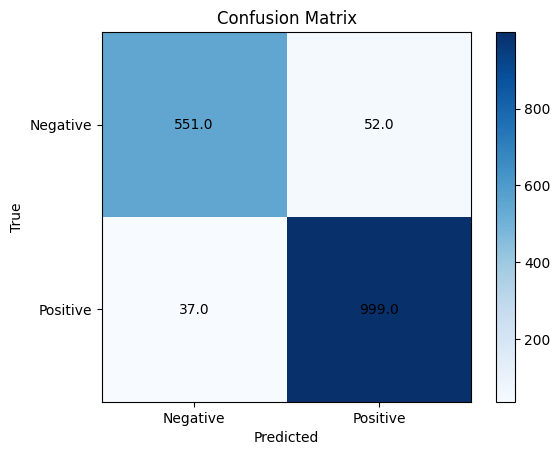

[[551.  52.]
 [ 37. 999.]]


In [61]:
print(hog.test_model(pos_test_dir=pos_test,neg_test_dir=neg_test))